## Etape 1 : Scraping des résultats depuis bases.athle

Objectifs :
+ créer un pipeline pour récupérer les données d'une compétition d'athlétisme (course sur route, trail, cross, ...)
+ retourner ces données sous la forme d'une table relationnelle
+ par la suite, exploiter cette table pour créer des statistiques et visualisations sur les compétitions

Format d'une URL de bases.athle :
+ ? avant la requête
+ & pour ajouter des paramètres à la recherche 

bases.athle.fr/asp.net/liste.aspx**?frmbase=resultats**&**frmmode=1**&**frmespace=0**&**frmcompetition=**274211

Liste des paramètres pour une recherche par athlète :
+ frmsaison
+ frmclub
+ frmnom
+ frmprenom
+ frmsexe
+ frmlicence
+ frmdepartement
+ frmligue
+ frmcomprch


### Installation de la libraire lxml

In [1]:
!pip install lxml

You should consider upgrading via the 'c:\users\trist\anaconda3\python.exe -m pip install --upgrade pip' command.


### Import des librairies requises

In [2]:
import lxml
import urllib
import bs4
import pandas as pd
import numpy as np
import re
from urllib import request

In [153]:
page = bs4.BeautifulSoup(request_text, "lxml")

Les pages de résultats de base.athle possèdent toutes la même forme, mais les en-têtes et les informations sur les différentes courses diffèrent en termes de contenu.

Par exemple, il peut y avoir les classements des équipes dans l'en-tête, ce qui rend le scraping complexe, puisqu'il faut différencier ces résultats des résultats individuels. Des informations supplémentaires sur les compétitions (société de chronométrage, etc.) peuvent être présentes dans l'en-tête également.

La cellule suivante récupère uniquement la table des résultats individuels en supprimant les cases contenant :
+ des résultats de groupes "groups"
+ l'en-tête principale "mainheaders"
+ l'en-tête de la table "barButtons"
+ le sous-titre de la table "subheaders"

In [289]:
nb_pages=4
url="https://bases.athle.fr/asp.net/liste.aspx?frmbase=resultats&frmmode=1&frmespace=0&frmcompetition=267449&frmposition="

In [290]:
L=[]
for i in range(nb_pages):
    url=url+str(i)
    request_text = request.urlopen(url).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    for i in page.find_all('tr'):
        if "groups" not in str(i) and "mainheaders" not in str(i) and "barButtons" not in str(i) and "subheaderscom" not in str(i):
            L.append(i)

### Dictionnaires utiles

#### Catégories de performance et cotation d'après table FFA

In [6]:
#bareme et table de cotation
#source: https://www.athle.fr/asp.net/main.html/html.aspx?htmlid=125

perf = {'IA': 40, 'IB': 35, #international
        'N1': 30, 'N2': 28, 'N3': 26, 'N4': 24, #national
        'IR1': 21, 'IR2': 20, 'IR3': 19, 'IR4': 18, #inter-regional
        'R1': 15, 'R2': 14, 'R3': 13, 'R4': 12, 'R5': 11, 'R6': 10, #regional
        'D1': 8, 'D2': 7, 'D3': 6, 'D4': 5, 'D5': 4, 'D6': 3, 'D7': 2} #departemental

#### Catégories d'âge d'après la réglementation FFA

In [7]:
#categories d'âge en 2023
#source: https://www.athle.fr/asp.net/main.html/html.aspx?htmlid=25

cat = {'M10': 'Masters 10', 'M9': 'Masters 9', 'M8': 'Masters 8', 'M7': 'Masters 7', 'M6': 'Masters 6',
       'M5': 'Masters 5', 'M4': 'Masters 4', 'M3': 'Masters 3', 'M2': 'Masters 2', 'M1': 'Masters 1', 'M0': 'Masters 0',
       'SE': 'Seniors',
       'ES': 'Espoirs',
       'JU': 'Juniors',
       'CA': 'Cadet.te.s',
       'MI': 'Minimes',
       'BE': 'Benjamin.e.s',
       'PO': 'Poussins',
       'EA': 'École d\'Athlétisme',
       'BB': 'Baby Athlé'}

In [8]:
#ajout de féminin (F) et masculin (M) aux categories

categoriesF=list(cat.keys())

#ajout des catégories féminines
for i in range(len(categoriesF)):
    categoriesF[i]+='F'
categoriesM=list(cat.keys())

#ajout des catégories masculines
for i in range(len(categoriesM)):
    categoriesM[i]+='M'
    
categories=categoriesF+categoriesM

## Date, nom, lieu, ligue, label et département de la compétition

In [9]:
header = page.find('div', {'class' : "mainheaders"})
header=str(header)
print(header)

<div class="mainheaders">09/04/22 - Championnats de France de 10 km<br/><span style="font-size:13px">BOULOGNE SUR MER - H-F - 062 - Label National</span></div>


#### Nom de la compétition

In [10]:
re_nom = re.compile("(?<=\- )(.*?)(?=\<)")
text = re_nom.findall(header)
nom = text[0]
sous_titre = text[1]
print(nom)

Championnats de France de 10 km


#### Lieu de la compétition

In [11]:
re_lieu = re.compile("(?<=\>)(\D*?)(?=\ -)")
lieu = re_lieu.findall(header)[0]
print(lieu)

BOULOGNE SUR MER


#### Date de la compétition

In [12]:
re_date = re.compile("[0-9]{2}/[0-9]{2}/[0-9]{2}")
date = re_date.findall(header)[0]
print(date)

09/04/22


#### Département de la compétition

In [13]:
re_dept = re.compile("[0-9]{3}")
dept = re_dept.findall(sous_titre)[0]
print(dept)

062


#### Label de la compétition (en cours)

In [14]:
re_label = re.compile("(?<=Label ).*(?<!')")
try:
    label = re_label.findall(sous_titre)[0]
    print(label)
except IndexError:
    print("Pas de label pour cette compétition")

National


#### Données de la compétition sous forme de dictionnaire

In [15]:
compet= {'nom': nom,
      'lieu': lieu,
      'date': date,
      'dept': dept,
      'label': label}

In [16]:
compet

{'nom': 'Championnats de France de 10 km',
 'lieu': 'BOULOGNE SUR MER',
 'date': '09/04/22',
 'dept': '062',
 'label': 'National'}

## Athlètes et chronos de la compétition

### Athlètes

In [291]:
re_athlete = re.compile("[A-Z]{2,} ?-?[A-Z]* ?-?[A-Z]* ?-?[A-Z]*[A-Z]{1}[a-z]+ ?-?[A-Z]?[a-z]*")

In [292]:
athletes=[]
for i in L:
    athletes.append(re_athlete.findall(str(i)))
athletes=[x for x in athletes if x!=[]]
athletes[:10]

[['GILAVERT Louis'],
 ['DAGUINOS Etienne'],
 ['CHRISTIEN Donovan'],
 ['MEKDAFOU Youssef'],
 ['KADDOUR Said '],
 ['MHAIMER Said '],
 ['BRULET Mathieu'],
 ['LEGENDRE Romain'],
 ['LASCABETTES Paul'],
 ['FANOUILLERE Benoit']]

### Chronos de la compétition

In [293]:
re_temps = re.compile("<b>(?=\d).*(?=<\/b>)")

In [294]:
temps=[]
for i in L:
    temps.append(re_temps.findall(str(i)))
temps=[x for x in temps if x!=[]]
for i in range(len(temps)):
    temps[i]=temps[i][0].replace("<b>","")
    temps[i]=pd.to_datetime(temps[i], format='%Hh%M\'%S\'\'', errors='ignore')
    temps[i]=pd.to_datetime(temps[i], format='%M\'%S\'\'', errors='ignore')
    temps[i]=pd.to_datetime(temps[i], format='%S\'\'', errors='ignore')
temps[:5]

[Timestamp('1900-01-01 00:14:03'),
 Timestamp('1900-01-01 00:14:05'),
 Timestamp('1900-01-01 00:14:10'),
 Timestamp('1900-01-01 00:14:12'),
 Timestamp('1900-01-01 00:14:20')]

### Ligue des athlètes

In [295]:
re_ligue = re.compile("[A-Z]{3,}(?=<)|[A-Z]-[A-Z](?=<)")

In [296]:
ligue=[]
for i in L:
    match = re_ligue.search(str(i))
    if (match==None) or (match.group() in categories):
        ligue.append('0')
    else:
        ligue.append(match.group())
ligue[:10]

['0', '0', 'I-F', 'N-A', 'BRE', 'I-F', 'OCC', 'OCC', 'N-A', 'PCA']

### Cotations des performances

In [297]:
re_perf = re.compile("[A-Z]{1}[1-8](?=<)|I[A,B](?=<)")

In [298]:
perfs=[]
for i in L:
    match= str(re_perf.findall(str(i))).replace('[','').replace(']','').replace('\'','')
    if match in list(perf.keys()):
        perfs.append(match)
    else:
        perfs.append('')
perfs[:10]

['', '', 'N3', 'N3', 'N3', 'N3', 'N3', 'N4', 'N4', 'N4']

### Catégories des athlètes

In [299]:
re_cat = re.compile("[A-Z]{3}(?=<)|[A-Z]{1}\d[A-Z]{1}")

In [300]:
categorie=[]
for i in L:
    match = re_cat.search(str(i))
    if (match==None):
        categorie.append(None)
    else:
        match = re_cat.findall(str(i))
        if len(match)>1 and (match[1] in categories):
            categorie.append(match[1])
        else:
            if (match[0] in categories):
                categorie.append(match[0])
categorie[:10]

[None, None, 'SEM', 'SEM', 'SEM', 'SEM', 'SEM', 'SEM', 'M0M', 'SEM']

### Années de naissance

In [301]:
re_annee = re.compile("\/[0-9]{2}<")

In [302]:
annee=[]
for i in L:
    match = re_annee.search(str(i))
    if (match==None) or (match.group() in categories):
        annee.append('0')
    else:
        year = int(str(match.group()).replace('/','').replace('<',''))
        if year <=20:
            annee.append(year+2000)
        else:
            annee.append(year+1900)

In [203]:
annee[:10]

['0', '0', 1985, 1993, 1993, 1995, 1992, 1993, 1985, 1989]

### Clubs des athlètes (en cours)

In [303]:
re_club = re.compile("[A-Z][a-z]+ *-*[A-Z][a-z]+ *-*[A-Z]*[a-z] *-*[A-Z]*[a-z]*(?=<)")

In [304]:
clubs=[]
for i in L:
    match = re_club.findall(str(i))
clubs[:10]

[]

### Suppression des lignes ne contenant pas les enregistrements des athlètes

In [305]:
len(athletes), len(perfs), len(ligue), len(clubs), len(annee), len(categorie)

(812, 820, 820, 0, 820, 818)

In [306]:
#identification du début de la table de résultats individuels à l'aide de la liste des catégories 

i = 0
while categorie[i]==None:
    i+=1
debut=i
print(debut)

2


In [307]:
liste=[]
for i in range(len(athletes)):
    ligne=[]
    ligne.append(athletes[i][0])
    ligne.append(ligue[i+debut])
    #ligne.append(str(clubs[i+debut]))
    ligne.append(temps[i])
    ligne.append(perfs[i+debut])
    ligne.append(annee[i+debut])
    ligne.append(categorie[i+debut])
    liste.append(ligne)

IndexError: list index out of range

In [308]:
data=pd.DataFrame(liste, columns=["Athlète", "Ligue", 
                                  #"Club",
                                  "Chrono", "Performance", "Naissance", "Catégorie"])

In [309]:
data['hours']=data['Chrono'].dt.hour
data['minutes']=data['Chrono'].dt.minute
data['seconds']=data['Chrono'].dt.second

In [310]:
data['time_delta']=data['Chrono']-pd.to_datetime("'1900-01-01")
data=data.sort_values('time_delta')

In [311]:
data=data.reset_index(drop=True)

In [312]:
data['time_gap']=data["Chrono"]-data['Chrono'][0]
data['duration']=data['time_delta'].dt.total_seconds()

#data['Nom']=data['Athlète'].str.split(n = 0, expand = False).str[0]
#data['Prénom']=data['Athlète'].str.split(n = 0, expand = False).str[1]

data=data.drop("Chrono", axis=1)
data.head(10)

,Athlète,Ligue,Performance,Naissance,Catégorie,hours,minutes,seconds,time_delta,time_gap,duration
0,GILAVERT Louis,I-F,N3,1998,SEM,0,14,3,0 days 00:14:03,0 days 00:00:00,843.0
1,DAGUINOS Etienne,N-A,N3,2000,SEM,0,14,5,0 days 00:14:05,0 days 00:00:02,845.0
2,CHRISTIEN Donovan,BRE,N3,1998,SEM,0,14,10,0 days 00:14:10,0 days 00:00:07,850.0
3,MEKDAFOU Youssef,I-F,N3,1992,SEM,0,14,12,0 days 00:14:12,0 days 00:00:09,852.0
4,KADDOUR Said,OCC,N3,1998,SEM,0,14,20,0 days 00:14:20,0 days 00:00:17,860.0
5,MHAIMER Said,OCC,N4,1997,SEM,0,14,23,0 days 00:14:23,0 days 00:00:20,863.0
6,BRULET Mathieu,N-A,N4,1987,M0M,0,14,24,0 days 00:14:24,0 days 00:00:21,864.0
7,LEGENDRE Romain,PCA,N4,2000,SEM,0,14,28,0 days 00:14:28,0 days 00:00:25,868.0
8,LASCABETTES Paul,I-F,N4,1996,SEM,0,14,33,0 days 00:14:33,0 days 00:00:30,873.0
9,FANOUILLERE Benoit,BRE,N4,1994,SEM,0,14,34,0 days 00:14:34,0 days 00:00:31,874.0


In [313]:
data.describe()

,hours,minutes,seconds,time_delta,time_gap,duration
count,770.0,770.000000,770.000000,770,770,770.000000
mean,0.0,18.418182,31.049351,0 days 00:18:56.140259740,0 days 00:04:53.140259740,1136.140260
std,0.0,3.537895,17.706395,0 days 00:03:33.010957952,0 days 00:03:33.010957952,213.010958
min,0.0,14.000000,0.000000,0 days 00:14:03,0 days 00:00:00,843.000000
25%,0.0,16.000000,15.250000,0 days 00:16:20,0 days 00:02:17,980.000000
50%,0.0,18.000000,31.000000,0 days 00:18:10,0 days 00:04:07,1090.000000
75%,0.0,20.000000,48.000000,0 days 00:20:31.750000,0 days 00:06:28.750000,1231.750000
max,0.0,39.000000,59.000000,0 days 00:39:59,0 days 00:25:56,2399.000000


### Premier exemple de visualisation : distribution des chronos

<AxesSubplot:ylabel='Density'>

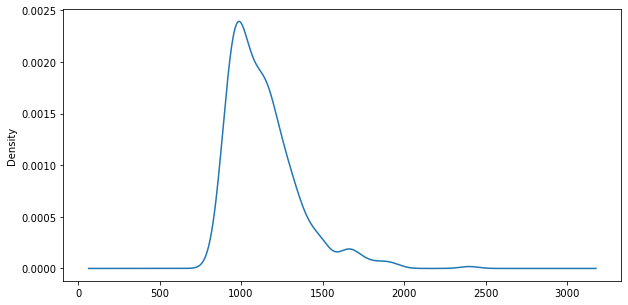

In [314]:
data["duration"].plot(kind='kde', figsize=(10,5))

### Deuxième exemple de visualisation : écart avec le premier

<AxesSubplot:>

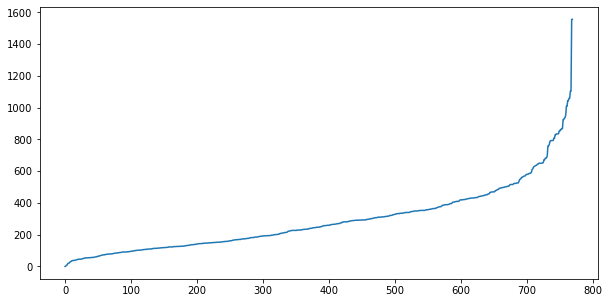

In [315]:
data["time_gap"].dt.total_seconds().plot(figsize=(10,5))

### Troisième exemple de visualisation : histogramme des performances (labels FFA)

<AxesSubplot:>

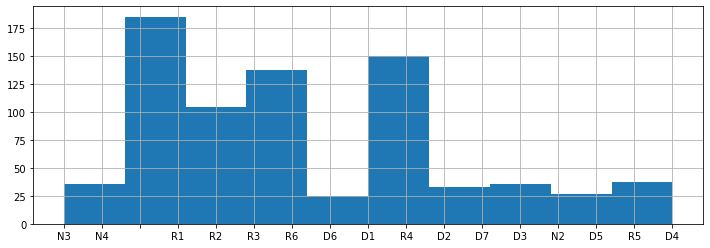

In [316]:
data["Performance"].hist(figsize=(12,4))

<AxesSubplot:>

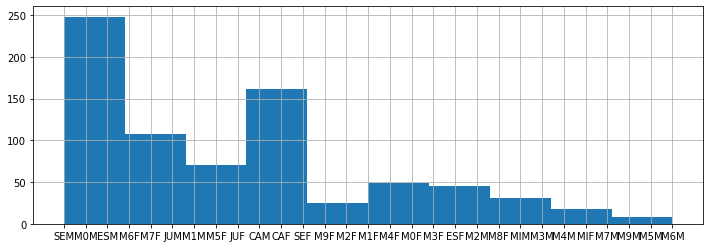

In [317]:
data["Catégorie"].hist(figsize=(12,4))

### Exemple output en csv

In [324]:
#data=data.drop("Club", axis=1)
data.to_csv("France2022_5KM_TC.csv", index=False)